In [305]:
global A
A = [ [0, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1,1,0,0,1,0],[0,1,0,0,0,0,0,0,1,0],[0,1,1,1,1,1,1,1,1,0],
    [0,1,0,1,0,0,1,0,1,0],[0,1,0,0,0,0,0,0,1,0],[0,0,1,1,1,1,1,1,0,0],[0,0,0,1,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0,1,0] ]

def DisplayMat(A):
    for i in range(len(A)):
        print(A[i])  
#DisplayMat(A)

def creemat(n,m): #n liste de longueur m
    l=[]
    ml=[]
    for i in range(n):
        for j in range(m):
            ml.append(0)
        l.append(ml)
        ml=[]
    return l
#creemat(4,3)

def CopyMat(A):
    lignecopy=[]
    l=[]
    for i in range(len(A)):
        for j in A[i]:
            lignecopy.append(j)
        l.append(lignecopy)
        lignecopy=[]
    return l
#CopyMat(A)

Fonctions pour passer d'image $ppm$ ou $pgm$ ($P2$) vers une $matrice$, et réciproque

In [306]:
def MatToIm(nom,valeurmax,matrice):
    file = open(nom,"w")
    file.write("P2\n")
    n = len(matrice)
    m = len(matrice[0])
    file.write("%d %d\n" %(m,n)) # ecrire les dimensions
    file.write("%d\n" %valeurmax)
    for ligne in matrice:
        for k in ligne:
            file.write(str(k))
            file.write(" ")
        file.write("\n")
    file.close()
MatToIm("PGM2Test.pgm",7,A)

def ImToMat(nom):
    file = open(nom,"r")
    file.readline() # sauter la première ligne
    
    ligne=file.readline() # lecture de la seconde ligne
    ligne=ligne.split(" ")
    nbligne = ligne[0] # nombre de lignes de l’image
    nbcol = ligne[1] # nombre de colonnes de l’image
    valeurmax = int(file.readline()) # valeur maximale pour le niveaux de gris
    
    matl=[]
    mat=[]
    for ligne in file.readlines(): #Construction de la matrice 
        ligne=ligne.split(" ")
        for i in range(len(ligne)-1):
            matl.append(int(ligne[i]))
        mat.append(matl)
        matl=[]

    return(mat,valeurmax)
#ImToMat("PGM2Test.pgm")

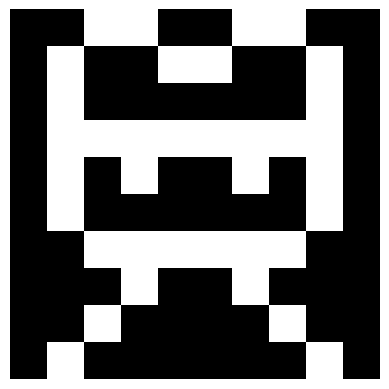

In [307]:
import matplotlib.pyplot as plt
plt.imshow(ImToMat("/Users/popov/Desktop/CatFinder/PGM2Test.pgm")[0],cmap=plt.get_cmap("gray")) # A est la matrice des pixels
plt.axis("off")
plt.show()

Fonctions additionnelles pour traiter des images grises

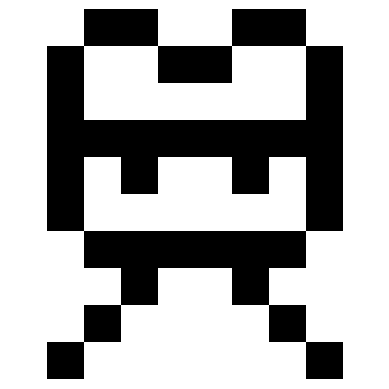

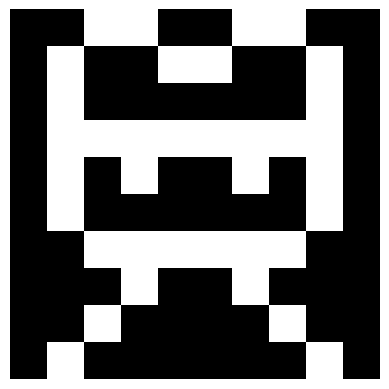

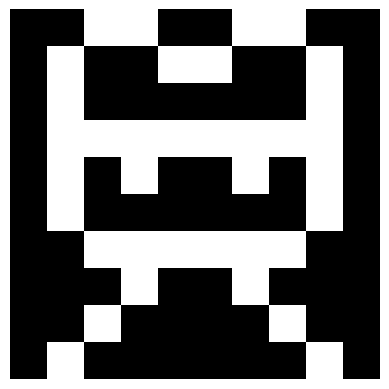

In [308]:
def inverser_gris(matrice,valeurmax):
    matl=[]
    mat=[]
    for i in range(len(matrice)):
        for j in range(len(matrice[i])):
            matl.append(valeurmax-matrice[i][j])
        mat.append(matl)
        matl=[]
    return (mat)
plt.imshow(inverser_gris(ImToMat("PGM2Test.pgm")[0],ImToMat("PGM2Test.pgm")[1]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

def Luminance(matrice):
    compteurP=0
    compteurV=0
    for i in range(len(matrice)):
        for j in range(len(matrice[i])):
            compteurP+=1
            compteurV=compteurV+matrice[i][j]
    return (compteurV/compteurP)
#print(Luminance(ImToMat("PGM2Test.pgm")[0]))

def estpair(mat):
    pair=False
    if len(mat)%2==0:
        pair=True
    return pair

def symetrie_verticale_gris(matrice):
    if estpair(matrice[0]):
        for z in range(len(matrice)):
            for i in range(0,len(matrice[0])//2,1):
                matrice[z][i],matrice[z][-(i+1)]=matrice[z][-(i+1)],matrice[z][i]
        return matrice
    else :
        for z in range(len(matrice)):
            for i in range(len(matrice)):
                matrice[z][i],matrice[z][-(i+1)]=matrice[z][-(i+1)],matrice[z][i]
        return matrice
        
        
plt.imshow((ImToMat("PGM2Test.pgm")[0]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

plt.imshow(symetrie_verticale_gris(ImToMat("PGM2Test.pgm")[0]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

Maintenant on applique nos fonctions précédentes directement sur des $PNG$ ou $JPEG$. $\\$
On commence par une fonction $convertir(A)$ pour une conversion de la forme $x \rightarrow \frac{x}{N}$ pour avoir des valeurs d'intensité de pixel dans $[0,1]$ en vue d'un calcul de gradien

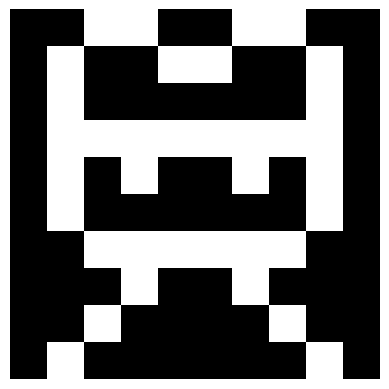

In [309]:
def convertir(A):
    maxi=0
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j]>maxi:
                maxi=A[i][j]
    N=maxi
    for i in range(len(A)):
        for j in range(len(A[i])):
            A[i][j]=A[i][j]/N
    return(A)

B=convertir(ImToMat("PGM2Test.pgm")[0])
plt.imshow(B,cmap="gray")
plt.axis("off")
plt.show()

# Gradien
$G_x(i,j)=(i+1,j)-(i-1,j) \\
G_y(i,j)=(i,j+1)-(i,j-1) \\$ Puis on garde $\sqrt{G_x^2(i,j)+G_y^2(i,j)} \\$
Optimisation : $G_x(i,j)=\frac{G_x(i,j)+G_x(i-1,j)+G_x(i+1,j)}{3}$ de même pour $G_y$

In [310]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#path="/Users/popov/Desktop/CatFinder/Capture d’écran 2025-08-18 à 16.04.55.png"

#img = Image.open(path).convert("L")   # "L" = grayscale

def transmo(A):
    arr = np.array(A, dtype=np.float32)       # matrice de float
    mat=[]
    for i in arr:
        matl=[]
        for j in i:
            matl.append(j)
        mat.append(matl)
    return mat

#B=convertir(transmo(img))

#plt.imshow(B , cmap="gray")
#plt.axis("off")
#plt.show()

def gradienOptimise(A):
    mat=[]
    maxgrad=0
    
    for i in range(2,len(A)-2):
        
        matl=[]
        
        for j in range(2,len(A[i])-2):
            
            Gx=((A[i+1][j]-A[i-1][j])+(-A[i-2][j])+(A[i+2][j]))/3
            Gy=((A[i][j+1]-A[i][j-1])+(-A[i][j-2])+(A[i][j+2]))/3
            grad=(Gx**2+Gy**2)**0.5
            matl.append(grad)
            
            
            if grad>maxgrad:
                maxgrad=grad
                
        mat.append(matl)
        
    return (mat,maxgrad)

#B=convertir(gradienOptimise(transmo(img))[0])
#plt.imshow(B, cmap="gray")
#plt.axis("off")
#plt.show()

def FiltreGrad(A):
    maxgrad=gradienOptimise(A)[1]
    mat=[]
    for i in range(0,len(A)):
        matl=[]
        for j in range(0,len(A[i])):
            if A[i][j]>maxgrad/3:
                matl.append(1)
            else : 
                matl.append(0)
                
        mat.append(matl)
    return mat


#B=convertir(FiltreGrad(gradienOptimise(transmo(img))[0]))
#plt.imshow(B, cmap="gray")
#plt.axis("off")
#plt.show()

# --- Directories ---
input_dir = "/Users/popov/Desktop/CatFinder/Cat Data"
output_dir = "/Users/popov/Desktop/CatFinder/Cat Data Processed"

os.makedirs(output_dir, exist_ok=True)  # crée le dossier de sortie si besoin

# --- Traitement batch ---
for img_path in glob.glob(os.path.join(input_dir, "*.png")): 
    filename = os.path.basename(img_path)
    print(f"Traitement de {filename}...")
    
    img = Image.open(img_path).convert("L")
    mat = transmo(img)
    
    # Calcul du gradient
    grad_mat = FiltreGrad(gradienOptimise(transmo(img))[0])
    B = convertir(grad_mat)
    
    # Sauvegarde
    output_path = os.path.join(output_dir, filename)
    plt.imsave(output_path, B, cmap="gray") 
print("Process terminé")

Traitement de ChatGPT2.png...
Traitement de ChatGPT3.png...
Traitement de ChatGPT1.png...
Process terminé


Partie $Deep \_ Learning$ avec $1$ $neurone$

In [311]:
from utilities import *
X_train, y_train, X_test, y_test = load_data()

In [326]:
X_train=X_train.reshape(X_train.shape[0],-1) / X_train.max()
X_test=X_test.reshape(X_test.shape[0],-1) / X_test.max()
def initialisation(X):
    W = np.random.randn(X.shape[1], 1) #matrice colonne
    b = np.random.randn(1)
    return W,b

def modele(X,W,b):
    Z = X @ W + b
    A = 1 / ( 1 + np.exp(-Z) )
    return A

def logloss(A,y):
    eps=1e-15
    return - 1/len(y) * np.sum(y*np.log(A+eps)+(1-y)*np.log(1-A+eps))

def gradient(A,X,y):
    dW=1/len(y) * X.T @ (A-y)
    db=1/len(y) * np.sum(A-y)
    return dW,db

def update(W,dW,b,db,alpha): #alpha : taux d'apprentissage
    W=W-alpha*dW
    b=b-alpha*db
    return W,b

def predict(X, W, b):
    A = modele(X, W, b)
    return A >= 0.5

from tqdm import tqdm
from sklearn.metrics import accuracy_score
def Neurone(X_train,y_train,X_test,y_test,alpha=0.01,n_iter = 1000):
    
    W,b=initialisation(X_train)
    erreur_train=[]
    score_train=[] #sklearn.metrics
    
    erreur_test=[]
    score_test=[]
    
    for i in tqdm(range(n_iter)):
        
        #train
        A = modele(X_train, W, b)
        dW, db = gradient(A, X_train, y_train)
        W, b = update(W,dW,b,db,alpha)

        erreur_train.append(logloss(A,y_train)) #visualiser l'apprentissage 
        score_train.append(accuracy_score(y_train,predict(X_train,W,b)))
        
        #test
        A_test = modele(X_test, W, b)
        erreur_test.append(logloss(A_test,y_test)) #visualiser l'apprentissage 
        score_test.append(accuracy_score(y_test,predict(X_test,W,b)))
    
    
    plt.plot(erreur_test,label="erreur_test")
    plt.plot(erreur_train,label="erreur_train")
    plt.legend()
    plt.show()
    plt.plot(score_test,label="score_test")
    plt.plot(score_train,label="score_train")
    plt.legend()
    plt.show()
    return (W, b)

Stocker les poids et le biai

100%|██████████| 2000/2000 [00:15<00:00, 128.22it/s]


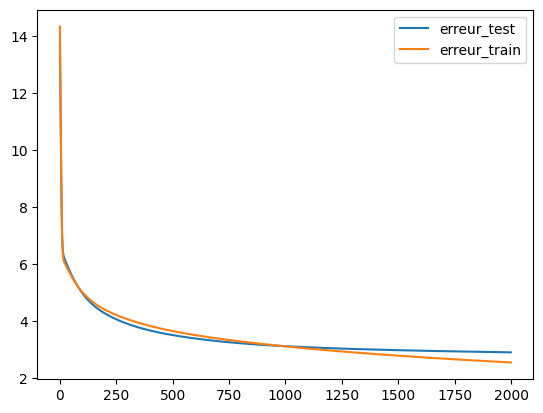

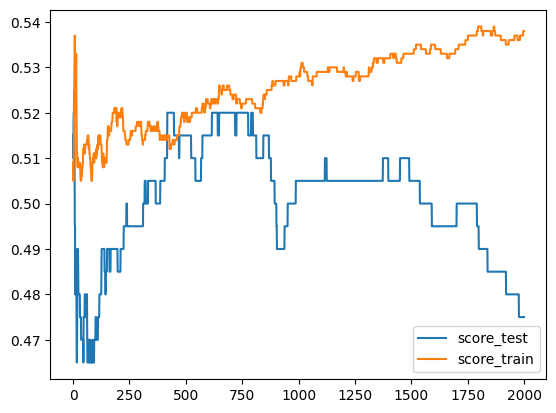

In [327]:
W, b = Neurone(X_train,y_train,X_test,y_test,alpha=0.01,n_iter = 2000)

Réseau de neuronne avec 2 couches avec $n1$ neurones dans la couche 1 et $n2$ neurones dans la couche 2

In [330]:
from utilities import *
X_train, y_train, X_test, y_test = load_data()
X_train=X_train.reshape(X_train.shape[0],-1) / 255
X_test=X_test.reshape(X_test.shape[0],-1) / 255

def initialisation(n0,n1,n2):
    W1=np.random.randn(n1, n0) #matrice colonne
    b1=np.random.randn(n1, 1)
    W2=np.random.randn(n2, n1)
    b2=np.random.randn(n2, 1)
    return W1,b1,W2,b2

def froward_propagation(X,W1,b1,W2,b2):
    Z1 = W1 @ X + b1
    A1 = 1 / ( 1 + np.exp(-Z1) )
    Z2 = W2 @ A1 +b2
    A2 = 1 / ( 1 + np.exp(-Z2) )
    return Z1,A1,Z2,A2

def back_propagation(A1,A2,W1,W2,X,y):
    dZ2=A2-y
    dW2=(1/len(y))*dZ2 @ A1.T
    db2=(1/len(y))*np.sum(dZ2,axis=1,keepdims=True) #Pour eviter que db2 soit de dim (n) au lieu de (n,1)
    
    dZ1=W2.T @ dZ2 * ( A1 * (1-A1) )
    dW1=(1/len(y))* dZ1 @ X.T
    db1=(1/len(y))* np.sum(dZ1,axis=1,keepdims=True)
    
    return dW1,dW2,db1,db2

def logloss(A,y):
    eps=1e-15
    return - 1/len(y) * np.sum(y*np.log(A+eps)+(1-y)*np.log(1-A+eps))

def update(W1,W2,b1,b2,dW1,dW2,db1,db2,alpha): #alpha : taux d'apprentissage
    W2=W2-alpha*dW2
    b2=b2-alpha*db2
    
    W1=W1-alpha*dW1
    b1=b1-alpha*db1
    
    return W1,W2,b1,b2

def predict(X,W1,b1,W2,b2):
    Z1,A1,Z2,A2 = froward_propagation(X,W1,b1,W2,b2)
    return A2 >= 0.5

def neural_network(X_train,y_train,X_test,y_test,n1,alpha,n_iter):
    
    X_train=X_train.T
    y_train=y_train.T
    
    X_test=X_test.T
    y_test=y_test.T
    
    n0=X_train.shape[0]
    n2=y_train.shape[0]
    W1,b1,W2,b2 = initialisation(n0,n1,n2)
    
    erreur_train=[]
    score_train=[] #sklearn.metrics
    
    erreur_test=[]
    score_test=[]
    
    for i in tqdm(range(n_iter)):
        
        #train
        Z1,A1,Z2,A2 = froward_propagation(X_train,W1,b1,W2,b2)
        dW1,dW2,db1,db2 = back_propagation(A1,A2,W1,W2,X_train,y_train)
        W1,W2,b1,b2 = update(W1,W2,b1,b2,dW1,dW2,db1,db2,alpha)

        #visualiser l'apprentissage
        erreur_train.append(logloss(A2.flatten(),y_train.flatten())) 
        y_pred = predict(X_train,W1,b1,W2,b2)
        score_train.append(accuracy_score(y_train.flatten(),y_pred.flatten()))
        
        #test
        Z1_test,A1_test,Z2_test,A2_test = froward_propagation(X_test,W1,b1,W2,b2)
        erreur_test.append(logloss(A2_test.flatten(),y_test.flatten())) #visualiser l'apprentissage 
        y_pred_test=predict(X_test,W1,b1,W2,b2)
        score_test.append(accuracy_score(y_test.flatten(),y_pred_test.flatten()))
        

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(erreur_test,label="erreur_test")
    plt.plot(erreur_train,label="erreur_train")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(score_test,label="score_test")
    plt.plot(score_train,label="score_train")
    plt.legend()
    plt.show()
    return (W1,b1,W2,b2)

100%|██████████| 2000/2000 [00:21<00:00, 92.01it/s]


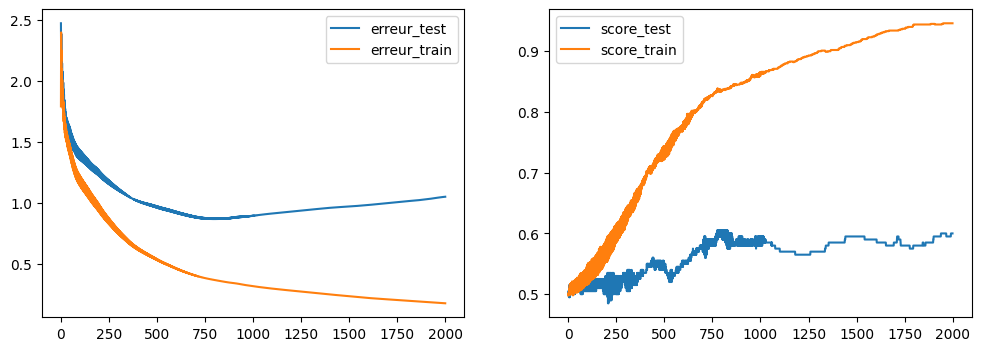

(array([[ 0.9335103 ,  2.90713211, -0.63004359, ...,  1.59167774,
          1.55022609,  0.73436203],
        [ 0.41282207, -0.26978818, -1.88222169, ...,  0.09840038,
         -2.18930627,  0.63786252],
        [-0.58034664, -1.58255859, -0.11612558, ...,  0.80943458,
          0.74839405,  0.52149306],
        ...,
        [ 1.54573526, -0.92655832,  0.88787733, ..., -0.79282897,
          1.13894871,  1.04179246],
        [ 0.75576058, -0.68010599, -0.38255468, ..., -1.21762642,
          1.83112908,  1.74791594],
        [ 0.69842517, -1.10550516, -0.9641937 , ...,  1.90541691,
         -0.08744549, -0.92149462]]),
 array([[-1.39478996],
        [-0.18823491],
        [-0.4096941 ],
        [-1.26612826],
        [ 2.08904765],
        [-1.82732412],
        [-0.16989298],
        [ 0.3662202 ],
        [-1.03085519],
        [-0.61102839],
        [-1.61051865],
        [-0.84233423],
        [ 0.85820301],
        [-0.85466472],
        [-0.78741803],
        [-0.53653676],
     

In [334]:
neural_network(X_train,y_train,X_test,y_test,n1=64,alpha=0.0005,n_iter=2000)